In [ ]:
# import shutil

In [ ]:
# shutil.rmtree('/content/.config')

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d teguhbudi/gym-tools 

 96% 25.0M/26.1M [00:02<00:00, 11.3MB/s]
100% 26.1M/26.1M [00:02<00:00, 13.1MB/s]


In [7]:
local_zip = '/content/gym-tools.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:

# from PIL import Image
# folder_path = '/content/data/training'
# extensions = []
# for fldr in os.listdir(folder_path):
#     sub_folder_path = os.path.join(folder_path, fldr)
#     for filee in os.listdir(sub_folder_path):
#         file_path = os.path.join(sub_folder_path, filee)
#         print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#         im = Image.open(file_path)
#         rgb_im = im.convert('RGB')
#         if filee.split('.')[1] not in extensions:
#             extensions.append(filee.split('.')[1])
    

In [ ]:
# !rm /content/data/Treadmill/treadmill-1.jpeg

In [ ]:
# rmdir /content/data/Dataset Gym Tools/Dataset Gym Tools/Dumbell/.ipynb_checkpointspoints

In [ ]:
# Mengimpor model pre-trained (misalnya, VGG16)
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [9]:
# # Membekukan lapisan-lapisan yang sudah dilatih pada model base
# for layer in base_model.layers:
#     layer.trainable = False


In [17]:
TRAINING_DIR = "/content/data/training"
VALIDATION_DIR = "/content/data/testing"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=30,      # Rentang rotasi dalam derajat
                                    width_shift_range=0.2,  # Jarak pergeseran horizontal dalam fraksi dari lebar gambar
                                    height_shift_range=0.2, # Jarak pergeseran vertikal dalam fraksi dari tinggi gambar
                                    zoom_range=0.2,         # Rentang zoom dalam fraksi
                                    horizontal_flip=True,   # Menerapkan pemutaran horizontal acak
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(160, 160))

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(160, 160))

Found 439 images belonging to 10 classes.
Found 59 images belonging to 10 classes.


In [18]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights = 'imagenet', include_top = False, input_shape =(160, 160, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [19]:
base_model.trainable = False

In [58]:
# x = base_model.output
# x = tf.keras.layers.MaxPooling2D()(x)
# x = Dense(256, activation='relu')(x)
# predictions = Dense(10, activation='softmax')(x)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [ ]:
# model = Model(inputs=base_model.input, outputs=predictions)

In [59]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 1280)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 5120)              0         
                                                                 
 dense_35 (Dense)            (None, 512)               2621952   
                                                                 
 dense_36 (Dense)            (None, 10)                5130      
                                                                 
Total params: 4,885,066
Trainable params: 2,627,082
No

In [62]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
class myCallback(tf.keras.callbacks.Callback):
    def set_model(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] < 0.15:
                self.model.stop_training = True

my_callback = myCallback()

In [66]:
history = model.fit(train_generator, epochs=10,
                    validation_data=validation_generator,
                    callbacks=[my_callback])


Epoch 1/10
14/14 [==============================] - 17s 1s/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.2772 - val_accuracy: 0.9322
Epoch 2/10
14/14 [==============================] - 17s 1s/step - loss: 0.0191 - accuracy: 0.9909 - val_loss: 0.4870 - val_accuracy: 0.8983
Epoch 3/10
14/14 [==============================] - 16s 1s/step - loss: 0.0442 - accuracy: 0.9841 - val_loss: 0.4129 - val_accuracy: 0.8814
Epoch 4/10
14/14 [==============================] - 16s 1s/step - loss: 0.0354 - accuracy: 0.9863 - val_loss: 0.4903 - val_accuracy: 0.8475
Epoch 5/10
14/14 [==============================] - 16s 1s/step - loss: 0.0136 - accuracy: 0.9954 - val_loss: 0.3807 - val_accuracy: 0.8814
Epoch 6/10
14/14 [==============================] - 16s 1s/step - loss: 0.0119 - accuracy: 0.9977 - val_loss: 0.4173 - val_accuracy: 0.8814
Epoch 7/10
14/14 [==============================] - 15s 1s/step - loss: 0.0205 - accuracy: 0.9954 - val_loss: 0.3028 - val_accuracy: 0.9153
Epoch 8/10
14/14 [==

In [67]:
import matplotlib.pyplot as plt
import numpy as np

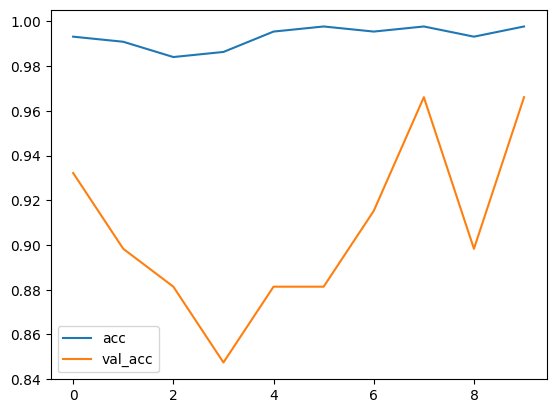

In [69]:
plt.plot(np.arange(len(history.history['loss'])), history.history['accuracy'])
plt.plot(np.arange(len(history.history['loss'])), history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()

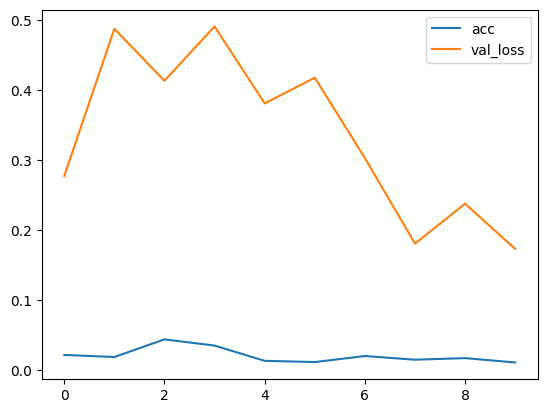

In [71]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'])
plt.plot(np.arange(len(history.history['loss'])), history.history['val_loss'])
plt.legend(['acc', 'val_loss'])
plt.show()

In [72]:
from google.colab import files


In [73]:
from PIL import Image
import numpy as np

In [88]:
image = files.upload()

Saving treadmill-49.jpeg to treadmill-49.jpeg


In [89]:
for i in image.keys():
  path = i

In [90]:
image = Image.open(i)
image = np.asarray(image.resize((160, 160)))
image = image/255
image = np.expand_dims(image, 0)

In [91]:
result = np.argmax(model.predict(image))

1/1 [==============================] - 0s 173ms/step


In [92]:
if result == 0:
  print('Barbell')
elif result == 1:
  print('Dumbell')
elif result == 2:
  print('Gym ball')
elif result == 3:
  print('Kattle ball')
elif result == 4:
  print('Leg press')
elif result == 5:
  print('Punching bag')
elif result == 6:
  print('Roller ABS')
elif result == 7:
  print('Statis bicycle')
elif result == 8:
  print('Step')
elif result == 9:
  print('Treadmill')

Treadmill


In [93]:
model.save('something.h5')